## vLife Virtusa
### Antibiotic Resistance  Predictor
### Usecase Description
The use case identifies whether a sample (formed as a combination of 16 unitig gene sequences ) is resistant to antibiotic ciprofloxacin or not for the treatment of Gonorrhoea, one of the most common sexually-transmitted bacterial infections.


In this project, you will learn how to fit a model for predicting resistance in bacteria, and see how different forms of cross-validation impact the interpretation of your performance results.

We will be focussing on a species called Neisseria gonorrhoeae, bacteria which cause gonorrhoea. Gonorrhoea is the second most common sexually transmitted infection (STI) in Europe, after chlamydia. Rates of gonorrhoea infection are on the rise, with a 26% increase reported from 2017-2018 in the UK.

Many people who are infected (especially women) experience no symptoms, helping its spread. However if the infection is left untreated, it can lead to infertility in women, and can occasionally spread to other parts of the body such as your joints, heart valves, brain or spinal cord.

In the past, patients were treated with an antibiotic called ciprofloxacin. Doctors had to stop using this antibiotic because resistance to the drug became too common, causing treatments if infections to fail. Until very recently, the recommended treatment was two drugs - ceftriaxone and azithromycin. Azithromycin was removed from recommendations because of concern over rising resistance to the antibiotic. Currently, in the UK, patients are only treated with ceftriaxone. In February 2018, the first ever reported case of resistance to treatment with ceftriaxone and azithromycin, as well as resistance to the last-resort treatment spectinomycin, was reported.

We will look at machine learning algorithms for predicting resistance to both ciprofloxacin and azithromycin.

### Data Source
Data for this usecase is  available [here](https://www.kaggle.com/nwheeler443/gono-unitigs)

## Dataset Description
For this project, we will be working with "unitigs", which are segments of DNA shared by a subset of the strains in our collection. This dataset contains unitigs that are statistically associated with resistance to three different antibiotics.

## Set Up Environment


In [2]:
import random
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

import matplotlib.pyplot as plt
import seaborn as sb
import time

> **function for preparing our training and testing data**


In [3]:
def prep_data(phenotype) :
    pheno = pd.read_csv('metadata.csv', index_col=0)
    pheno = pheno.dropna(subset=[phenotype]) # drop samples that don't have a value for our chosen resistance profile
    pheno = pheno[phenotype]
    
    # read in unitig data
    X = pd.read_csv('' + phenotype + '_gwas_filtered_unitigs.Rtab', sep=" ", index_col=0, low_memory=False)
    X = X.transpose()
    X = X[X.index.isin(pheno.index)] # only keep rows with a resistance measure
    pheno = pheno[pheno.index.isin(X.index)]
    return X, pheno


> **prepare our data for predicting ciprofloxacin resistance**

In [4]:
phenotype = 'cip_sr'
X, pheno = prep_data(phenotype)

# create an array for storing performance metrics
performance = []
method = []
times = []

> **look at the length distribution of the unitigs in our dataset**

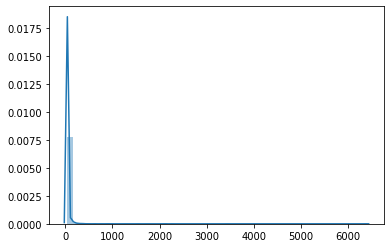

In [5]:
unitigs = X.columns
mylen = np.vectorize(len)
uni_len = mylen(unitigs)
sb.distplot(uni_len)

## Predictive Models
> **function for fitting a model**

In [7]:
def fitmodel(X, pheno, estimator, parameters, modelname, method, performance, times) :
    kfold = KFold(n_splits=5)
    for train_index, test_index in kfold.split(X, pheno):
        # time how long it takes to train each model type
        start = time.process_time()
        
        # split data into train/test sets
        X_train = X.iloc[train_index]
        y_train = pheno[train_index]
        X_test = X.iloc[test_index]
        y_test = pheno[test_index]
        
        # perform grid search to identify best hyper-parameters
        gs_clf = GridSearchCV(estimator=estimator, param_grid=parameters, cv=3, n_jobs=-1, scoring='balanced_accuracy')
        gs_clf.fit(X_train, y_train)
        
        # predict resistance in test set
        y_pred = gs_clf.predict(X_test)
        y_pred[y_pred<0.5] = 0
        y_pred[y_pred>0.5] = 1

        score = balanced_accuracy_score(y_test, y_pred)
        performance = np.append(performance, score)
        method = np.append(method, modelname)
        times = np.append(times, (time.process_time() - start))

        print("Best hyperparameters for this fold")
        print(gs_clf.best_params_)
        print("Confusion matrix for this fold")
        print(confusion_matrix(y_test, y_pred))
    return gs_clf, method, performance, times


In [9]:
kfold = KFold(n_splits=5)
for train_index, test_index in kfold.split(X, pheno):
        # time how long it takes to train each model type
        #start = time.process_time()
        
        # split data into train/test sets
        X_train = X.iloc[train_index]
        y_train = pheno[train_index]
        X_test = X.iloc[test_index]
        y_test = pheno[test_index]

In [10]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 15))
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=15, n_jobs=None,
                                                 oob_score=False,


In [11]:
sel.get_support()

selected_feat= X_train.columns[(sel.get_support())]
len(selected_feat)

selected_feat1 = selected_feat[::50]
print(selected_feat1)

Index(['CTTGCTGGAAAAGGCGTTTTTACGGTTTGGAATGCCTGTTGCCGTGGTTG',
       'GCCCGCATTGAATGCAAATTCATAAGTAATCAGCGGAAA',
       'AAAGAGCTTGAGGCTTTGGCGTGTGCGGCATCGGCTTGGA',
       'CACAACGCCCCGCTATTCCGAAGCGGTTTGCGCGGGCGGCTT',
       'GCGGACATCAGCGCGAATATGTACCGTCCGCATGACGAAGAACTCGGCGTATTCGTGCAGC',
       'CTGGAAAATCAAAGCCGTGCCGAAAGTCTTGGACAAAGCCAAAG',
       'AAAGACAAGAGCAAAGTGTGGAATACCGCGCGTATCGA',
       'CTGACGGGCTCGGGCATCTGCCAAAATTTCG',
       'CTGACGGGGATTTCAGACGGCATGGTTGCCGACGCGCCG',
       'CAAACCAAACAGCAACAAGTCATGCAGCGGGCAAAAGCCGAA',
       'CCTACGCCCGCGCGATGCTGCGGGGCGAGGCGCACAACC',
       'CCTTGAGTGCTGAAGAAAAAGAACTGCTTGC', 'GCCATTTACGCCCAATCCCAAGCCGTCGCCC',
       'TTCTTAAAAAGCAACCTTGATATTTCAATGCAG',
       'CCACAGCGGAGAAGAAGTCATACCGGAACGTGCACGG',
       'GACCATCGCGGCCTTTGAAAAACGCATAGCC'],
      dtype='object', name='pattern_id')


In [12]:
X_final = X[[c for c in X.columns if c in selected_feat1]]
X_final

pattern_id,CTTGCTGGAAAAGGCGTTTTTACGGTTTGGAATGCCTGTTGCCGTGGTTG,GCCCGCATTGAATGCAAATTCATAAGTAATCAGCGGAAA,AAAGAGCTTGAGGCTTTGGCGTGTGCGGCATCGGCTTGGA,CACAACGCCCCGCTATTCCGAAGCGGTTTGCGCGGGCGGCTT,GCGGACATCAGCGCGAATATGTACCGTCCGCATGACGAAGAACTCGGCGTATTCGTGCAGC,CTGGAAAATCAAAGCCGTGCCGAAAGTCTTGGACAAAGCCAAAG,AAAGACAAGAGCAAAGTGTGGAATACCGCGCGTATCGA,CTGACGGGCTCGGGCATCTGCCAAAATTTCG,CTGACGGGGATTTCAGACGGCATGGTTGCCGACGCGCCG,CAAACCAAACAGCAACAAGTCATGCAGCGGGCAAAAGCCGAA,CCTACGCCCGCGCGATGCTGCGGGGCGAGGCGCACAACC,CCTTGAGTGCTGAAGAAAAAGAACTGCTTGC,GCCATTTACGCCCAATCCCAAGCCGTCGCCC,TTCTTAAAAAGCAACCTTGATATTTCAATGCAG,CCACAGCGGAGAAGAAGTCATACCGGAACGTGCACGG,GACCATCGCGGCCTTTGAAAAACGCATAGCC
SRR1661154,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,1
SRR1661156,0,0,0,0,0,0,0,0,1,1,0,1,1,1,1,1
SRR1661157,0,0,0,0,0,1,0,0,1,1,0,0,1,0,1,1
SRR1661158,0,0,1,0,0,0,0,0,0,1,0,0,1,1,1,1
SRR1661159,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR5827366,0,0,0,0,0,0,0,0,1,1,0,1,1,0,1,1
SRR5827371,0,0,0,0,0,0,0,0,1,1,0,0,1,1,1,1
SRR5827372,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,1
SRR5827369,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,1


> **Random Forest Classifier Hyper param tuning**

In [13]:
rf = RandomForestClassifier(random_state=0, n_jobs=-1, class_weight="balanced")
rf_params = {
    'max_features': [round(X_final.shape[1]*0.1), round(X_final.shape[1]*0.5), round(X_final.shape[1]*0.8)],
    'max_depth': [3],
    'n_estimators': [50]
}

rf_model, method, performance, times = fitmodel(X_final, pheno,rf , rf_params, "Random forest", method, performance, times)

Best hyperparameters for this fold
{'max_depth': 3, 'max_features': 2, 'n_estimators': 50}
Confusion matrix for this fold
[[279  42]
 [ 35 262]]
Best hyperparameters for this fold
{'max_depth': 3, 'max_features': 2, 'n_estimators': 50}
Confusion matrix for this fold
[[283  68]
 [ 20 247]]
Best hyperparameters for this fold
{'max_depth': 3, 'max_features': 2, 'n_estimators': 50}
Confusion matrix for this fold
[[247  79]
 [ 46 246]]
Best hyperparameters for this fold
{'max_depth': 3, 'max_features': 2, 'n_estimators': 50}
Confusion matrix for this fold
[[254  80]
 [ 16 267]]
Best hyperparameters for this fold
{'max_depth': 3, 'max_features': 2, 'n_estimators': 50}
Confusion matrix for this fold
[[272  56]
 [ 31 258]]


> **Persist Machine Learning Model**

In [15]:
import pickle 
pickle.dump(rf_model, open('rf_model.pkl', 'wb'))

## Model Evaluation

In [23]:
kfold = KFold(n_splits=5)
for train_index, test_index in kfold.split(X_final, pheno):
        # time how long it takes to train each model type
        start = time.process_time()
        
        # split data into train/test sets
        X_train = X_final.iloc[train_index]
        y_train = pheno[train_index]
        X_test = X_final.iloc[test_index]
        y_test = pheno[test_index]

In [27]:
X_test

pattern_id,AGAGTAAACGTACTCAACCAGGTACAAGCAGGGGTCAGCCAGATGTTCGGTC,AGGCAACCTGTTTGCCAACTGGACGGGCGCGCTGCTCATC,CCGCGAAGCCAACCTGCACGATTTGTTACGCCGC,TCAAACCGCCCTCTTTCATCCCCGCGCCGAGC,AATCCCCTCGCAGCACGCCCCCGAAGACTACCCCGACATCCAAAGCGCG,TTTGAAGACGCGCTGCTGATGGGTTGCGGCGAACG,GGGATTGTAAAAATAAATGGTGTAGTCGATGCCGGAG,CAGCCTGACCCATTGCCATGCTGCTTGCCGC,ACCAATTACGCCGGCAAACGGGTCGAATCGGA,ATGACCGAACAACACTTTACCGAACAAATCAAATCCCTAATCGACAGCTTAAAAACCAT,TAACATACGGAAACCTTTTATTCATTGAGTGAGGTCGATTATGCT,ACAATGCGTTATTGGCGGAACACTTCACTAAA,CGATTACGACAACGCCGACAACGTGGTGTACCAAACCC,GCCGCGTATAAAAACCCATCAGGAAAGATGCAA,GTTAATTTTTGTTAATCATCCCTTCTTAGGGACGCAAT,GTAGCGGTCGGCAGAACCTTGGCTCATCGCGCCCAA
15335_2#80,0,0,0,0,0,1,0,0,1,1,0,1,0,1,1,1
15335_2#78,0,0,0,0,1,1,0,0,1,0,0,1,0,1,1,1
15335_7#75,0,0,0,0,0,1,0,0,1,0,0,1,0,1,1,1
15335_7#78,0,0,0,0,0,1,0,0,1,1,0,1,0,1,1,1
15335_2#61,0,0,0,0,0,1,0,0,1,0,0,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR5827366,0,0,1,0,0,0,0,1,1,1,1,0,1,0,1,1
SRR5827371,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,1
SRR5827372,0,0,0,0,0,0,0,1,0,1,0,1,1,1,1,1
SRR5827369,0,0,0,0,0,0,1,0,1,0,0,1,0,1,1,1


In [32]:
df= pd.DataFrame(data=y_pred)

In [37]:
##test
res = y_pred[0]== 1.0 ? 'true' : 'false'

print(" For the given sequences present in the sample id " + X_test.index[0] + "Ciprofloxacin is not resistant" )

 For the given sequences present in the sample id 15335_2#80Ciprofloxacin is not resistant 1.0


> **predict resistance in test set**


In [25]:
y_pred = rf_model.predict(X_test)
y_pred

array([1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1.,
       1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0.,
       1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       1., 0., 1., 0., 1.

In [17]:
selected_feat1

Index(['CTTGCTGGAAAAGGCGTTTTTACGGTTTGGAATGCCTGTTGCCGTGGTTG',
       'GCCCGCATTGAATGCAAATTCATAAGTAATCAGCGGAAA',
       'AAAGAGCTTGAGGCTTTGGCGTGTGCGGCATCGGCTTGGA',
       'CACAACGCCCCGCTATTCCGAAGCGGTTTGCGCGGGCGGCTT',
       'GCGGACATCAGCGCGAATATGTACCGTCCGCATGACGAAGAACTCGGCGTATTCGTGCAGC',
       'CTGGAAAATCAAAGCCGTGCCGAAAGTCTTGGACAAAGCCAAAG',
       'AAAGACAAGAGCAAAGTGTGGAATACCGCGCGTATCGA',
       'CTGACGGGCTCGGGCATCTGCCAAAATTTCG',
       'CTGACGGGGATTTCAGACGGCATGGTTGCCGACGCGCCG',
       'CAAACCAAACAGCAACAAGTCATGCAGCGGGCAAAAGCCGAA',
       'CCTACGCCCGCGCGATGCTGCGGGGCGAGGCGCACAACC',
       'CCTTGAGTGCTGAAGAAAAAGAACTGCTTGC', 'GCCATTTACGCCCAATCCCAAGCCGTCGCCC',
       'TTCTTAAAAAGCAACCTTGATATTTCAATGCAG',
       'CCACAGCGGAGAAGAAGTCATACCGGAACGTGCACGG',
       'GACCATCGCGGCCTTTGAAAAACGCATAGCC'],
      dtype='object', name='pattern_id')

In [54]:
def input_seq(selected_feature):
    x_test1 = []
    for c in selected_feature :
        print(c)
        x_test1.append(input("enter whether unitig is present or not (0/1)"))
        
    print (x_test1)
    
sample1=[random.randint(0, 1) for iter in range(16)]

16

In [101]:
sample1
df_sample = pd.DataFrame(data = sample1, )

df_sample1 = df_sample.transpose()
df_sample1.columns = list_feat
df_sample1

,AGAGTAAACGTACTCAACCAGGTACAAGCAGGGGTCAGCCAGATGTTCGGTC,AGGCAACCTGTTTGCCAACTGGACGGGCGCGCTGCTCATC,CCGCGAAGCCAACCTGCACGATTTGTTACGCCGC,TCAAACCGCCCTCTTTCATCCCCGCGCCGAGC,AATCCCCTCGCAGCACGCCCCCGAAGACTACCCCGACATCCAAAGCGCG,TTTGAAGACGCGCTGCTGATGGGTTGCGGCGAACG,GGGATTGTAAAAATAAATGGTGTAGTCGATGCCGGAG,CAGCCTGACCCATTGCCATGCTGCTTGCCGC,ACCAATTACGCCGGCAAACGGGTCGAATCGGA,ATGACCGAACAACACTTTACCGAACAAATCAAATCCCTAATCGACAGCTTAAAAACCAT,TAACATACGGAAACCTTTTATTCATTGAGTGAGGTCGATTATGCT,ACAATGCGTTATTGGCGGAACACTTCACTAAA,CGATTACGACAACGCCGACAACGTGGTGTACCAAACCC,GCCGCGTATAAAAACCCATCAGGAAAGATGCAA,GTTAATTTTTGTTAATCATCCCTTCTTAGGGACGCAAT,GTAGCGGTCGGCAGAACCTTGGCTCATCGCGCCCAA
0,0,0,1,1,1,1,0,0,1,0,0,1,0,0,1,0


In [76]:
a = X_test.columns

In [ ]:
y_pred1 = rf_model.predict(df_sample1)
y_pred1

print( " for seq or input " df_sample1)

In [96]:
list_feat = list(selected_feat1)
list_feat

['AGAGTAAACGTACTCAACCAGGTACAAGCAGGGGTCAGCCAGATGTTCGGTC',
 'AGGCAACCTGTTTGCCAACTGGACGGGCGCGCTGCTCATC',
 'CCGCGAAGCCAACCTGCACGATTTGTTACGCCGC',
 'TCAAACCGCCCTCTTTCATCCCCGCGCCGAGC',
 'AATCCCCTCGCAGCACGCCCCCGAAGACTACCCCGACATCCAAAGCGCG',
 'TTTGAAGACGCGCTGCTGATGGGTTGCGGCGAACG',
 'GGGATTGTAAAAATAAATGGTGTAGTCGATGCCGGAG',
 'CAGCCTGACCCATTGCCATGCTGCTTGCCGC',
 'ACCAATTACGCCGGCAAACGGGTCGAATCGGA',
 'ATGACCGAACAACACTTTACCGAACAAATCAAATCCCTAATCGACAGCTTAAAAACCAT',
 'TAACATACGGAAACCTTTTATTCATTGAGTGAGGTCGATTATGCT',
 'ACAATGCGTTATTGGCGGAACACTTCACTAAA',
 'CGATTACGACAACGCCGACAACGTGGTGTACCAAACCC',
 'GCCGCGTATAAAAACCCATCAGGAAAGATGCAA',
 'GTTAATTTTTGTTAATCATCCCTTCTTAGGGACGCAAT',
 'GTAGCGGTCGGCAGAACCTTGGCTCATCGCGCCCAA']

In [94]:
y_pred1 = rf_model.predict(df_sample1)
y_pred1

array([1.])

## END